In [12]:
%%html
<!-- left align tables -->
<style>
table {margin-left: 0 !important;}
</style>

# Identify Persons of Interest in the Enron Corpus Dataset

## Introduction


## Data Exploration

### Dataset Description

email
https://www.cs.cmu.edu/~./enron/

finance
http://news.findlaw.com/hdocs/docs/enron/enron61702insiderpay.pdf

In [13]:
# import packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
# helper functions
def convert_dict_to_df(dictionary, features, remove_NaN=True, 
                        remove_all_zeroes=True, remove_any_zeroes=False, 
                        sort_keys=False):
    """
    Convert dictionary to a pandas data frame of features.
    
    Args:
        dictionary: Dictionary containing the feature names as keys and the 
            corresponding values.
        features: List of feature names. First feature passed needs to be 'poi'.
        remove_NaN: True converts all "NaN" strings to 0.
        remove_all_zeroes: True omits all 0 data points.
        remove_any_zeroes: True omits single 0 data points.
        sort_keys: True sorts the dictionary keys in alphabetical order before
            adding the data points to the data frame.

    Returns:
        Function returns a pandas data frame with each row representing a data 
        point with the specified features in its columns.
    """

    # check that first feature passed is 'poi'
    assert (features[0] == 'poi'), "The first feature needs to be 'poi'!"

    # data frame to store the data points as individual rows
    df = pd.DataFrame(columns=['name'] + features)

    # sort keys alphabetically if sort_keys is set to True
    if sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    # loop trough the data dictionary 
    for key in keys:
        
        val_dict = {'name': key} # first entry of data point is the name of the person

        for feature in features:
            # check if specified feature exists, throw a warning if not and 
            # stop the function
            try:
                val = dictionary[key][feature]
            except KeyError:
                print("error: key ", feature, " not present")
                return

            val = dictionary[key][feature]

            # set 'NaN' strings to np.NaN values
            if val == "NaN" and not remove_NaN:
                val = np.NaN
            # set NaN values to 0 if remove_NaN is set to True
            elif val == "NaN" and remove_NaN:
                val = 0

            val_dict[feature] = val

        # do not add all zero data points if remove_all_zeroes is set to True
        if remove_all_zeroes:       
            append = False
            for key, val in val_dict.items(): 
                if key != 'poi' and key != 'name': # exclude 'poi' and 'name' from criteria
                    if val != 0 and val != "NaN":
                        append = True
                        break
        
        # don not add single zero data points if remove_any_zeroes is set to 
        # True
        elif remove_any_zeroes:
            append = True
            keys =  [f for f in features if f not in ('poi', 'name')] # exclude 'poi' and 'name' from criteria
            val_list = [val_dict.get(k) for k in keys] # list containing values of remaining features

            if 0 in val_list or "NaN" in val_list:
                append = False
        
        # all data points are added 
        else:
            append = True
    
        
        # append data point if it is flagged for addition
        if append:
            df = df.append(val_dict, ignore_index=True)
        
    return df


def scatter_plot(df, x, y, normalize=True):
    """
    
    """
    poi_df = df[df['poi'] == True]
    x_poi = poi_df[x].fillna(value=0).values.reshape(-1, 1)
    y_poi = poi_df[y].fillna(value=0).values.reshape(-1, 1)
    
    non_poi_df = df[df['poi'] == False]
    x_non_poi = non_poi_df[x].fillna(value=0).values.reshape(-1, 1)
    y_non_poi = non_poi_df[y].fillna(value=0).values.reshape(-1, 1)
    
    if normalize:
        x_poi = MinMaxScaler().fit_transform(x_poi)
        y_poi = MinMaxScaler().fit_transform(y_poi)
        
        x_non_poi = MinMaxScaler().fit_transform(x_non_poi)
        y_non_poi = MinMaxScaler().fit_transform(y_non_poi)
    
    # create plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(x_poi, y_poi, color="red", label="poi")
    ax.scatter(x_non_poi, y_non_poi, color="blue", label="non poi")
    ax.set(title="{} vs. {}".format(x, y), xlabel=x, xlim=[-0.02, 1.02], ylabel=y, ylim=[-0.02, 1.02])
    plt.legend()
    
    plt.show()

In [15]:
# load dictionary containing the dataset
with open("enron_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# feature list
features = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 
            'director_fees', 'exercised_stock_options', 'expenses', 
            'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
            'restricted_stock_deferred', 'salary', 'total_payments', 
            'total_stock_value', 'email_address', 'from_messages', 
            'from_poi_to_this_person', 'from_this_person_to_poi', 
            'shared_receipt_with_poi', 'to_messages']

# convert specified features to data frame
data_df = convert_dict_to_df(data_dict, features, remove_NaN=False, 
                        remove_all_zeroes=True, remove_any_zeroes=False, 
                        sort_keys=True)

print(data_df.shape)
print(len(list(data_df.columns.values)))
print(data_df['poi'].sum())

(146, 22)
22
18


The underlying dataset for this project is a combination of Enron email and financial data. The data is present in the `enron_dataset.pkl` file where it is stored in a dictionary structure. Each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. 

The data contains three major feature categories: POI labels, financial features and email features. The 21 feature names and their type are described in the table below.

| Feature                   | Type        |
|-------------------------- | ----------- |
| poi                       | categorical |
| bonus                     | numerical   |
| deferral_payments         | numerical   |
| deferred_income           | numerical   |
| director_fees             | numerical   |
| exercised_stock_options   | numerical   |
| expenses                  | numerical   |
| loan_advances             | numerical   |
| long_term_incentive       | numerical   |
| other                     | numerical   |
| restricted_stock          | numerical   |
| restricted_stock_deferred | numerical   |
| salary                    | numerical   |
| total_payments            | numerical   |
| total_stock_value         | numerical   |
| email_address             | text        |
| from_messages             | numerical   |
| from_poi_to_this_person   | numerical   |
| from_this_person_to_poi   | numerical   |
| shared_receipt_with_poi   | numerical   |
| to_messages               | numerical   |

The dataset contains information about 146 different data points. Of those, 18 are marked as POI.

Missing values...

In [16]:
# count number of NaN values in each column
print("Number of NaN values in each columns:")
print("-------------------------------------")
print(data_df.isnull().sum())

Number of NaN values in each columns:
-------------------------------------
name                           0
poi                            0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
loan_advances                142
long_term_incentive           80
other                         53
restricted_stock              36
restricted_stock_deferred    128
salary                        51
total_payments                21
total_stock_value             20
email_address                 35
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
shared_receipt_with_poi       60
to_messages                   60
dtype: int64


The dataset contains a lot of features with missing values. One can see that it is based on the finacial data and that only for 86 point a connection to the email dataset could be made (60 data points without email data). For the features 'deferral_payments', 'director_fees', 'loan_advances' and 'restricted_stock_deferred' the fewest amount of  data is available.

### Outliers

In the financial data a strange outlier was found. This data point had the largest values for all the different financial feature and was identified as the total column from the spreadsheet. Futhermore, I discovered the key 'THE TRAVEL AGENCY IN THE PARK' which is not the name of a person as well as the data point of 'LOCKHART EUGENE E' that consists of all zero values. These lines were dropped and not considered further.

In [17]:
# drop 'TOTAL' row
for n in ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']:
    data_df = data_df[data_df['name'] != n]

print(data_df.shape)

(143, 22)


log scaling of skewed distributions???

### Feature Engineering

Before selecting the features that influence 'poi' labelling the most I created two new features. First of all, I thought about looking at the ratio between 'restricted_stock' and 'total_stock_value'. As POIs in general had higher stock options maybe they also tried to prevent those from being restricted leading to low values for the 'poi_email_fraction'. Secondly, I created a new variable comparing the number of emails received from and sent to POIs with the total number of email received and sent by each pearson. I would expect POIs to communicate more frequently with other POIs and thus having higher 'poi_email_fraction' values.

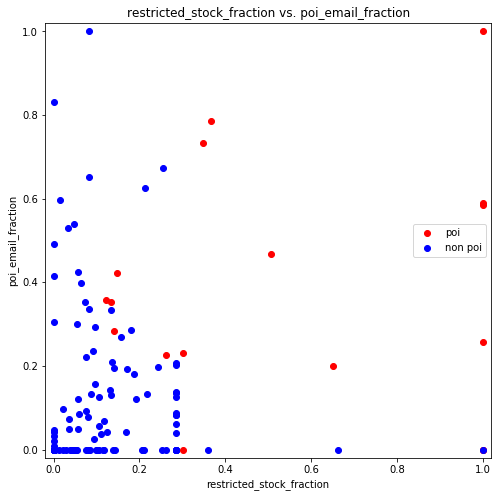

In [18]:
# poi fraction
data_df['restricted_stock_fraction'] = data_df['restricted_stock'] / data_df['total_stock_value']
data_df['poi_email_fraction'] = (data_df['from_poi_to_this_person'] + data_df['from_this_person_to_poi']) / (data_df['from_messages'] + data_df['to_messages'])

# visualization
scatter_plot(data_df, 'restricted_stock_fraction', 'poi_email_fraction')

By visualizing these new featuers one can see that all but one POI have a 'poi_email_fraction' larger than 0.2. The point that breaks ranks occurs as there is no email data for that person available. Most POIs have 'restricted_stock_fractions' between 0.2 and 0.7 but there are three data points that have all their stocks restircted.

### Feature Selection



SelectKBest

scales features for meaningful comparison

In [19]:
X = data_df.fillna(value=0).select_dtypes(include=[np.number])
y = data_df['poi']

selector = SelectKBest(k=X.shape[1])
selector.fit(X, y)

features = X[selector.get_support(indices=True)].columns.values
scores = selector.scores_
score_list = sorted([(f, s) for f, s in zip(features, scores)], key=lambda tup: tup[1], reverse=True)

for tup in score_list:
    print("{}: {}".format(tup[0], tup[1]))

exercised_stock_options: 24.815079733218194
total_stock_value: 24.18289867856688
bonus: 20.792252047181535
salary: 18.289684043404513
deferred_income: 11.458476579280369
long_term_incentive: 9.922186013189823
restricted_stock: 9.2128106219771
total_payments: 8.772777730091676
shared_receipt_with_poi: 8.589420731682381
loan_advances: 7.184055658288725
expenses: 6.094173310638945
poi_email_fraction: 5.399370288094401
from_poi_to_this_person: 5.243449713374958
other: 4.187477506995375
from_this_person_to_poi: 2.382612108227674
director_fees: 2.1263278020077054
to_messages: 1.6463411294420076
restricted_stock_fraction: 1.090157169632843
deferral_payments: 0.2246112747360099
from_messages: 0.16970094762175533
restricted_stock_deferred: 0.06549965290994214


For the rest of project we will focus on the ten features with the highest scores. Nine of these come from the financial data and only 'shared_receipt_with_poi' comes from the emails. Below, one can see the top five features visualized in a scatter matrix.

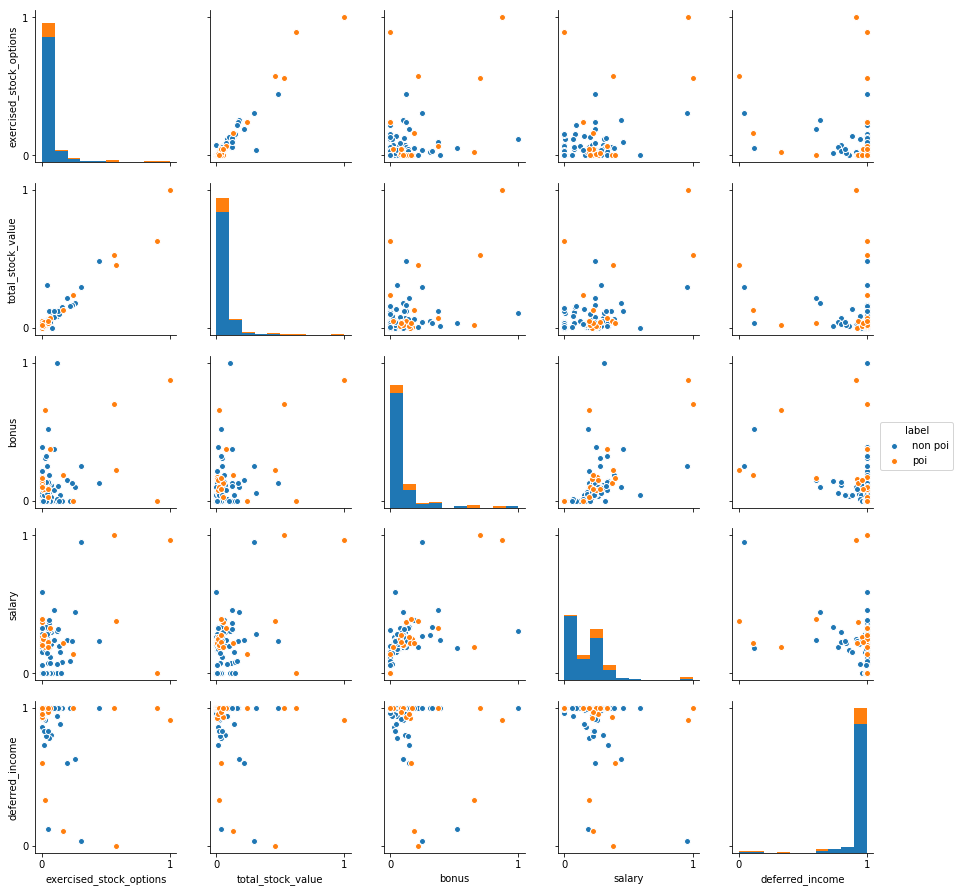

In [20]:
# create scatter matrix of the top 5 features
top_5_features = [f for (f, s) in list(score_list)[:5]]

# add 'poi' to include this feature in the plotting dataframe
plot_features = top_5_features
plot_features.append('poi')

# create dataframe copy with the desired columns for plotting
data_df_plot = data_df.loc[:, plot_features].fillna(value=0)

# scale all features except for 'poi'
scaler = MinMaxScaler()
data_df_plot[top_5_features[:-1]] = scaler.fit_transform(data_df_plot[top_5_features[:-1]])

# create 'label' feature as 'hue' input for sns.pairplot() 
data_df_plot['label'] = 0
data_df_plot.loc[data_df_plot['poi'] == True, 'label'] = 'poi'
data_df_plot.loc[data_df_plot['poi'] == False, 'label'] = 'non poi'

# remove 'poi' feature
data_df_plot.drop(['poi'], axis=1, inplace=True)

# create pairplot
fig = sns.pairplot(data_df_plot, hue="label", diag_kind="hist")  

# format axes
for i, axes in enumerate(fig.axes):
    for j, ax in enumerate(axes):
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        ax.set_xticklabels([0, 1])
        ax.set_xticks([0, 1])
        ax.set_yticklabels([0, 1])
        ax.set_yticks([0, 1])

plt.show()

interpretation scatter matrix


only use 'exercised_stock_options' or 'total_stock_value', strong correlation between these two features as expected

deferred_income is negative -> most values around 1

'loan_advances' contains only 3 non zero values 


replacement with 'expenses' and 'poi_email_fraction'

In [21]:
# store top 10 features in a list
top_10_features = [f for (f, s) in list(score_list)[:10]]
top_10_features.extend(['expenses', 'poi_email_fraction'])
top_10_features = [i for i in top_10_features if i not in ['total_stock_value', 'loan_advances']]

## Algorithm Selection


Random Forest Classifer, Support Vector Machine & Logistic Regression

`StratifiedShuffleSplit` because data is imbalanced and sensitive to input so we use kfold crossvalidation

still very  sensitive results, vary strongly each run




In [36]:
# data wrangling
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int)

# classifier names and objects    
names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Classifier', 'KNeighbors Classifier', 
         'Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']
classifiers =[LogisticRegression(),
              GaussianNB(),
              SVC(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              AdaBoostClassifier()]

# dictionary to store results of all validation runs
clf_results = {} 
for n in names:
    clf_results[n] = {'accuracy': [], 'precision': [], 'recall': []}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.33)

for train_ixs, test_ixs in sss.split(X, y):
    X_train, X_test = X.iloc[train_ixs], X.iloc[test_ixs]
    y_train, y_test = y.iloc[train_ixs], y.iloc[test_ixs]
    
    for n, clf in zip(names, classifiers):      
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
            
        accuracy = clf.score(X_test, y_test)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        
        clf_results[n]['accuracy'].append(accuracy)
        clf_results[n]['precision'].append(precision)
        clf_results[n]['recall'].append(recall)
        
print("{:<25} {:<10} {:<10} {}".format("Classifier", "Accuracy", "Precision", "Recall"))
print("------------------------------------------------------")
for n in names:
    accuracy = round(np.mean(clf_results[n]['accuracy']), 2)
    precision = round(np.mean(clf_results[n]['precision']), 2)
    recall = round(np.mean(clf_results[n]['recall']), 2)
    
    print("{:<25} {:<10} {:<10} {}".format(n, accuracy, precision, recall))

Classifier                Accuracy   Precision  Recall
------------------------------------------------------
Logistic Regression       0.89       0.6        0.12
Gaussian Naive Bayes      0.84       0.42       0.38
Support Vector Classifier 0.88       0.0        0.0
KNeighbors Classifier     0.86       0.15       0.03
Decision Tree Classifier  0.83       0.29       0.28
Random Forest Classifier  0.86       0.22       0.08
AdaBoost Classifier       0.82       0.25       0.2


three different metrics, accuracy is generally high because of the imbalace in the data und thus all models predict a large amount of non-POI correctly. Precision... . Recall... .
warning because classifier predicted no POI in the test set correctly

vary number of input features, from 1 to 10 based on feature selection ranking

'Stratified

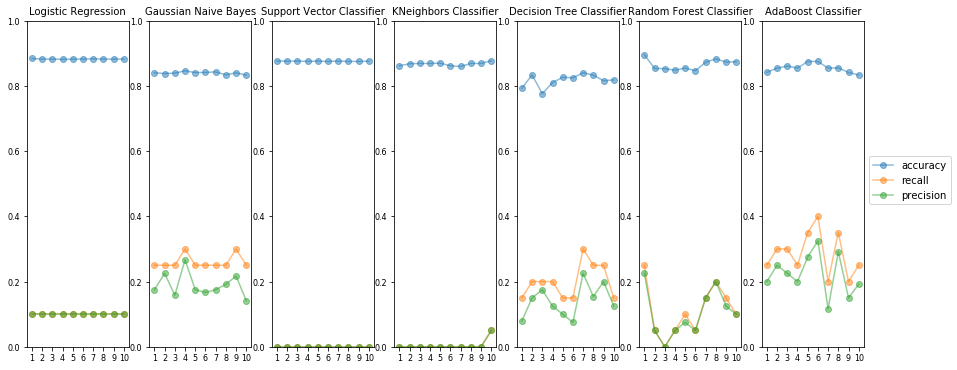

In [37]:
# vary number of input features and cross-validate train/test sample sizes
clf_results = {}   
for n, clf in zip(names, classifiers):
    clf_results[n] = {'accuracy': [], 'precision': [], 'recall': []}
    
    for i in range(1, len(top_10_features) + 1):
        accuracies, precisions, recalls = [], [], []
        features = top_10_features[:i]
        skf = StratifiedKFold(n_splits=20, shuffle=True)
        
        for train_ixs, test_ixs in skf.split(X, y):
            X_train, X_test = X.iloc[train_ixs], X.iloc[test_ixs]
            y_train, y_test = y.iloc[train_ixs], y.iloc[test_ixs]

            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            
            accuracy = clf.score(X_test, y_test)
            precison = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            
            accuracies.append(accuracy)
            precisions.append(precison)
            recalls.append(recall)
        
        accuracy_cv = np.mean(accuracies)
        precision_cv = np.mean(precisions)
        recall_cv = np.mean(recalls)
        
        clf_results[n]['accuracy'].append(accuracy_cv)
        clf_results[n]['precision'].append(precision_cv)
        clf_results[n]['recall'].append(recall_cv)

# visualize metrics for all algorithms
fig, axs = plt.subplots(1, len(names), figsize=(15, 6))
n_features = np.arange(1, len(top_10_features) + 1)

for ax, title in zip(axs, names):
    for m in clf_results[title].keys():
        ax.plot(n_features, clf_results[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[0.5, 10.5], xticks=n_features, ylim=[0.0, 1.0])
        ax.set_title(title, fontsize= 10)
        ax.tick_params(axis='both', which='major', labelsize=8)

plt.legend(loc='upper right', bbox_to_anchor=(1.9, 0.6))
plt.show()

In [41]:

"""
# vary number of input features and cross-validate train/test sample sizes
clf_results = {}   
for n, clf in zip(names, classifiers):
    clf_results[n] = {'accuracy': [], 'precision': [], 'recall': []}
    
    for i in range(1, len(top_10_features) + 1):
        accuracies, precisions, recalls = [], [], []
        features = top_10_features[:i]
        skf = StratifiedKFold(n_splits=20, shuffle=True)
        
        for train_ixs, test_ixs in skf.split(X, y):
            X_train, X_test = X.iloc[train_ixs], X.iloc[test_ixs]
            y_train, y_test = y.iloc[train_ixs], y.iloc[test_ixs]

            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            
            accuracy = clf.score(X_test, y_test)
            precison = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            
            accuracies.append(accuracy)
            precisions.append(precison)
            recalls.append(recall)
        
        accuracy_cv = np.mean(accuracies)
        precision_cv = np.mean(precisions)
        recall_cv = np.mean(recalls)
        
        clf_results[n]['accuracy'].append(accuracy_cv)
        clf_results[n]['precision'].append(precision_cv)
        clf_results[n]['recall'].append(recall_cv)

"""
clf_results = {} 
for n in names:
    clf_results[n] = {'accuracy': {}, 'precision': {}, 'recall': {}}
    
for key, vals in clf_results.items():
    for val in vals.keys():
        for i in range(1, len(top_10_features) + 1):
            clf_results[key][val][i] = []
        
for i in range(1, len(top_10_features) + 1):
    features = top_10_features[:i]
    X_i = X.loc[:, features]
    
    skf = StratifiedKFold(n_splits=20, shuffle=True)
    for train_ixs, test_ixs in skf.split(X, y):
        X_train, X_test = X_i.iloc[train_ixs], X_i.iloc[test_ixs]
        y_train, y_test = y.iloc[train_ixs], y.iloc[test_ixs]
        
        
        accuracies, precisions, recalls = [], [], []
        for n, clf in zip(names, classifiers):
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            
            accuracy = clf.score(X_test, y_test)
            precison = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            
            clf_results[n]['accuracy'][i].append(accuracy)

print(clf_results)
"""
# visualize metrics for all algorithms
fig, axs = plt.subplots(1, len(names), figsize=(15, 6))
n_features = np.arange(1, len(top_10_features) + 1)

for ax, title in zip(axs, names):
    for m in clf_results[title].keys():
        ax.plot(n_features, clf_results[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[0.5, 10.5], xticks=n_features, ylim=[0.0, 1.0])
        ax.set_title(title, fontsize= 10)
        ax.tick_params(axis='both', which='major', labelsize=8)

plt.legend(loc='upper right', bbox_to_anchor=(1.9, 0.6))
plt.show()
"""

{'Decision Tree Classifier': {'accuracy': {1: [0.75, 0.875, 0.8571428571428571, 0.75, 0.875, 0.8571428571428571, 1.0, 0.8571428571428571, 0.7142857142857143, 1.0, 0.8571428571428571, 0.5714285714285714, 0.8571428571428571, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 1.0], 2: [0.75, 1.0, 0.75, 0.75, 0.75, 1.0, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 1.0, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 0.8571428571428571, 1.0, 0.7142857142857143], 3: [0.875, 0.875, 0.875, 0.75, 0.875, 0.8571428571428571, 0.8571428571428571, 0.5714285714285714, 0.2857142857142857, 0.83333333333333337, 0.8571428571428571, 0.5714285714285714, 0.8571428571428571, 0.7142857142857143, 0.83333333333333337, 0.8571428571428571, 0.42857142857142855, 1.0, 0.8571428571428571, 0.8571428571428571], 4: [0.875, 0.875, 1.0, 0.875, 0.75, 1.0, 1.0, 0.8571428571428571, 0.714285714285

"\n# visualize metrics for all algorithms\nfig, axs = plt.subplots(1, len(names), figsize=(15, 6))\nn_features = np.arange(1, len(top_10_features) + 1)\n\nfor ax, title in zip(axs, names):\n    for m in clf_results[title].keys():\n        ax.plot(n_features, clf_results[title][m], label=m, marker='o', alpha=0.5)\n        ax.set(xlim=[0.5, 10.5], xticks=n_features, ylim=[0.0, 1.0])\n        ax.set_title(title, fontsize= 10)\n        ax.tick_params(axis='both', which='major', labelsize=8)\n\nplt.legend(loc='upper right', bbox_to_anchor=(1.9, 0.6))\nplt.show()\n"

GaussianNB, Decision Tree, Random Forest and AdaBoost seem to perform the best, focus on these four for the remaining analysis, no major influence of feature number on performance visible, stick with top 10

GridSeachCV for parameter optimization

GaussianNB: -


Decision Tree: criterion -> 'gini', 'entropy', min_samples_split -> 2, 5, 10


Random Forest: n_estimators -> 5, 10, 15, 20, criterion -> 'gini', 'entropy', min_samples_split -> 2, 5, 10


AdaBoost: n_estimators -> 20, 50, 100



In [ ]:
# remove SVC and KNeighbors from classifier lists
names = [n for n in names if n not in ['Logistic Regression', 'Support Vector Classifier', 'KNeighbors Classifier']]

ixs = [0, 2, 3]
for ix in sorted(ixs, reverse=True):
    del classifiers[ix]

In [ ]:
parameters = [{}, # GaussianNB has no parameters
              {'criterion': ['gini', 'entropy'], 'min_samples_split': {2, 5, 10}},
              {'n_estimators': [5, 10, 15, 20], 'criterion': ['gini', 'entropy'], 'min_samples_split': {2, 5, 10}},
              {'n_estimators' {20, 50, 100}}]

for n, clf in zip(names, classifiers):
clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)


## Validation and Evaluation

## Conclusion

best model...


## Find new features in emails.....??

In [ ]:
def get_email_from_filename(filename, start, end):
    """
    
    """
    email_address = ""
    
    m = re.search("{}(.*){}".format(start, end), filename)
    if m:
        email_address = m.group(1)
    
    return email_address

def get_path_from_fileline():
    pass

data_df[(data_df['poi'] == True)][['name', 'from_messages']]

In [ ]:
dir_path = "./emails_by_address/"

#from_poi_deleted_dict = {}

for filename in os.listdir(dir_path):
    # only check files with emails to that address
    if filename.startswith("to_"):
        # extract email from filename   
        email = get_email_from_filename(filename, "to\_", "\.txt")
        
        #from_poi_deleted_dict[email] = 0
        
        with open(os.path.join(dir_path, filename), 'r') as file:
            
            # loop trough lines in the file
            for line in file:
                path = line
                
                with open() as email:
                    
                
                """
                print(sender)
                folder = get_folder_from_fileline(line)
                
                if sender in poi_list and folder == "deleted_items":
                    from_poi_deleted_dict[email] += 1

"""
            
    